In [1]:
import pandas as pd

# Load the Excel file
file_path = 'https://docs.google.com/spreadsheets/d/1R7kmn9LtcGZFUCplZVN804NXsGWyUBHF/export?format=xlsx'
sheet_name = 'combinedata1'

# Read the specific sheet into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the DataFrame
df.head()


,Question,Answer
0,"Ẹ ǹlẹ́ o, Ẹlẹ́ran.","Ẹ ǹlẹ́ o, Oníbàárà."
1,Ṣé ajé ń wọgbá?,Olúwa ṣeun.
2,Eélòó ni kilo ẹran?,"N1, 300 ni kílò."
3,Ṣé jálẹ̀jálẹ̀ nì yẹn?,"Bẹ́ẹ̀ni, jálẹ̀jálẹ̀ nì yẹn. Kódà, àwọn kan ń t..."
4,"Ṣe bí o ti mọ, ẹlẹ́wà Ṣàpọn.",Òótó lẹ sọ.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3225 entries, 0 to 3224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  3225 non-null   object
 1   Answer    3225 non-null   object
dtypes: object(2)
memory usage: 50.5+ KB


In [4]:
df=df.dropna()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3225 entries, 0 to 3224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  3225 non-null   object
 1   Answer    3225 non-null   object
dtypes: object(2)
memory usage: 50.5+ KB


In [7]:
# Load the data and separate into train, validation and test data
import os
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path

from tqdm import tqdm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Let's now split up the data into train and validation sets
data=df.copy()
n = int(0.9*len(data)) # first 90% will be train, rest val
raw_train_dataset = data[:n]
raw_validation_dataset = data[n:]

In [10]:
#Create tokenizers

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

In [11]:
os.mkdir("./tokenizer_que")
os.mkdir("./tokenizer_ans")

In [12]:
def get_ds_iterator(raw_train_dataset, lang):
    for _, row in raw_train_dataset.iterrows():
        yield row[lang]



In [13]:
# Create Source Tokenizer - Question
tokenizer_en = Tokenizer(BPE(unk_token="[UNK]"))
trainer_en = BpeTrainer(min_frequency=2, special_tokens=["[PAD]","[UNK]","[CLS]", "[SEP]", "[MASK]"])
# We’ll also need to add a pre-tokenizer to split our input into words as without a pre-tokenizer, we might get tokens that overlap several words: for instance we could get a "there is" token since those two words often appear next to each other.
# Using a pre-tokenizer will ensure no token is bigger than a word returned by the pre-tokenizer.
tokenizer_en.pre_tokenizer = Whitespace()
tokenizer_en.train_from_iterator(get_ds_iterator(raw_train_dataset, "Question"), trainer=trainer_en)
tokenizer_en.save("./tokenizer_que/tokenizer_question.json")



In [14]:
# Create Target Tokenizer - answer
tokenizer_my = Tokenizer(BPE(unk_token="[UNK]"))
trainer_my = BpeTrainer(min_frequency=2, special_tokens=["[PAD]","[UNK]","[CLS]", "[SEP]", "[MASK]"])
tokenizer_my.pre_tokenizer = Whitespace()
tokenizer_my.train_from_iterator(get_ds_iterator(raw_train_dataset, "Answer"), trainer=trainer_my)
tokenizer_my.save("./tokenizer_ans/tokenizer_answer.json")


In [15]:
raw_train_dataset[0:1]

,Question,Answer
0,"Ẹ ǹlẹ́ o, Ẹlẹ́ran.","Ẹ ǹlẹ́ o, Oníbàárà."


In [16]:
tokenizer_que = Tokenizer.from_file("./tokenizer_que/tokenizer_question.json")
tokenizer_ans = Tokenizer.from_file("./tokenizer_ans/tokenizer_answer.json")

source_vocab_size = tokenizer_que.get_vocab_size()
target_vocab_size = tokenizer_ans.get_vocab_size()

# to calculate the max sequence lenth in the entire training dataset for the source and target dataset
max_seq_len_source = 0
max_seq_len_target = 0

for  _, data in raw_train_dataset.iterrows():
    enc_ids = tokenizer_en.encode(data['Question']).ids
    dec_ids = tokenizer_my.encode(data['Answer']).ids
    max_seq_len_source = max(max_seq_len_source, len(enc_ids))
    max_seq_len_target = max(max_seq_len_target, len(dec_ids))

print(f'max_seqlen_source: {max_seq_len_source}')   #99 - can be different in your case
print(f'max_seqlen_target: {max_seq_len_target}')   #109 - can be different in your case

# to make it standard for our training we'll just take max_seq_len_source and add 20-50 to cover the additional tokens such as PAD, CLS, SEP
max_seq_len = 225

max_seqlen_source: 81
max_seqlen_target: 170


In [17]:


# Transform raw dataset to the encoded dataset that can be processed by the model
class EncodeDataset(Dataset):
    def __init__(self, raw_dataset, max_seq_len):
        super().__init__()
        self.raw_dataset = raw_dataset
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, index):

        # fetching the single data for the given index value that consist of both question and response.
        raw_text = self.raw_dataset.iloc[index]

        # separating text by question and answer which will be later used for encoding.
        source_text = raw_text["Question"]
        target_text = raw_text['Answer']

        # Encoding both question and answer text
        source_text_encoded = tokenizer_en.encode(source_text).ids
        target_text_encoded = tokenizer_my.encode(target_text).ids

        # Convert the CLS, SEP and PAD tokens to their corresponding index id in vocabulary using tokenizer [the id would be same with either tokenizers]
        CLS_ID = torch.tensor([tokenizer_my.token_to_id("[CLS]")], dtype=torch.int64)
        SEP_ID = torch.tensor([tokenizer_my.token_to_id("[SEP]")], dtype=torch.int64)
        PAD_ID = torch.tensor([tokenizer_my.token_to_id("[PAD]")], dtype=torch.int64)

        # To train the model, the sequence lenth of each input should be equal max seq length. Hence additional number of padding will be added to the input sequence if the length is not equal to the max seq length.
        num_source_padding = self.max_seq_len - len(source_text_encoded) - 2
        num_target_padding = self.max_seq_len - len(target_text_encoded) - 1

        encoder_padding = torch.tensor([PAD_ID] * num_source_padding, dtype = torch.int64)
        decoder_padding = torch.tensor([PAD_ID] * num_target_padding, dtype = torch.int64)

        # encoder_input has the first token as start of senstence - CLS_ID, followed by source encoding which is then followed by the end of sentence token - SEP.
        # To reach the required max_seq_len, addition PAD token will be added at the end.
        encoder_input = torch.cat([CLS_ID, torch.tensor(source_text_encoded, dtype=torch.int64), SEP_ID, encoder_padding], dim=0)

        # decoder_input has the first token as start of senstence - CLS_ID, followed by target encoding.
        # To reach the required max_seq_len, addition PAD token will be added at the end. There is no end of sentence token - SEP in decoder input.
        decoder_input = torch.cat([CLS_ID, torch.tensor(target_text_encoded, dtype=torch.int64), decoder_padding ], dim=0)

        # target_label is required for the loss calculation during training to compare between the predicted and target label.
        # target_label has the first token as target encoding followed by actual target encoding. There is no start of sentence token - CLS in target label.
        # To reach the required max_seq_len, addition PAD token will be added at the end.
        target_label = torch.cat([torch.tensor(target_text_encoded, dtype=torch.int64),SEP_ID,decoder_padding], dim=0)

        # Since we've added extra padding token with input encoding, we don't want this token to be trained by model.
        # So, we'll use encoder mask to nullify the padding value prior to producing output of self attention in encoder block
        encoder_mask = (encoder_input != PAD_ID).unsqueeze(0).unsqueeze(0).int()

        # We don't want any token to get influence the future token during the decoding stage. Hence, Causal mask is being implemented during masked multihead attention to handle this.
        decoder_mask = (decoder_input != PAD_ID).unsqueeze(0).unsqueeze(0).int() & causal_mask(decoder_input.size(0))

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'target_label': target_label,
            'encoder_mask': encoder_mask,
            'decoder_mask': decoder_mask,
            'source_text': source_text,
            'target_text': target_text
        }

# Causal mask will make sure any token that comes after the current token will be masked meaning the value will be replaced by -infinity that will be converted to zero or neearly zero after softmax operation. Hence the model will just ignore these value or willn't be able to learn anything.
def causal_mask(size):
        # Creating a square matrix of dimensions 'size x size' filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

# create a dataloader to use for model training and validation
train_ds = EncodeDataset(raw_train_dataset, max_seq_len)
val_ds = EncodeDataset(raw_validation_dataset, max_seq_len)

train_dataloader = DataLoader(train_ds, batch_size = 5, shuffle = True)
val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

In [18]:
import torch
import torch.nn as nn
import math

#  Input embedding and positional encoding
class EmbeddingLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        # using pytorch models embedding layer to map token id to embedding vector which has the shape of (vocab_size, d_model)
        # The vocab_size is the vocabulary size of the training data created by tokenizer in step 2
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, input):
        # In addition of giving input to the embedding, the extra multiplication by square root of d_model is to normalize the embedding layer output
        embedding_output = self.embedding(input) * math.sqrt(self.d_model)
        return embedding_output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_seq_len: int, dropout_rate: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        pe = torch.zeros(max_seq_len, d_model)

        pos = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        # since we're expecting the input sentences in batches so the extra dimension to cater batch number needs to be added in 0 postion
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, input_embdding):
        input_embdding = input_embdding + (self.pe[:, :input_embdding.shape[1], :]).requires_grad_(False)   # to prevent from calculating gradient
        return self.dropout(input_embdding)

#  Multihead Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout_rate: float):
        super().__init__()
        # Defining dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)
        self.num_heads = num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by number of heads"

        # d_k is the new dimension of each self attention heads
        self.d_k = d_model // num_heads

        # Weight matrix are defined which are all learnable parameters
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def forward(self, q, k, v, encoder_mask):

        # Please note that we'll be training our model with not just a single sequence but rather batches of sequence, hence we'll include batch_size in the shape
        # query, Key and value are calculated by matrix multiplication of corresponding weights with the input embeddings
        # Change of shape: q(batch_size, seq_len, d_model) @ W_q(d_model, d_model) => query(batch_size, seq_len, d_model) [same goes to key and value]
        query = self.W_q(q)
        key = self.W_k(k)
        value = self.W_v(v)

        # Dividing query, key and value into number of heads, hence new dimenstion will be d_k.
        # Change of shape: query(batch_size, seq_len, d_model) => query(batch_size, seq_len, num_heads, d_k) -> query(batch_size,num_heads, seq_len,d_k) [same goes to key and value]
        query = query.view(query.shape[0], query.shape[1], self.num_heads ,self.d_k).transpose(1,2)
        key = key.view(key.shape[0], key.shape[1], self.num_heads ,self.d_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.num_heads ,self.d_k).transpose(1,2)

        # :: SELF ATTENTION BLOCK STARTS ::

        # Attention score is calculated to find the similarity or relation of query with key of itself and all other embedding in the sequence
        #  Change of shape: query(batch_size,num_heads, seq_len,d_k) @ key(batch_size,num_heads, seq_len,d_k) => attention_score(batch_size,num_heads, seq_len,seq_len)
        attention_score = (query @ key.transpose(-2,-1))/math.sqrt(self.d_k)

        # If mask is provided the attention score needs to modify as per the mask value. Refer to the details in point no 4.
        if encoder_mask is not None:
          attention_score.masked_fill_(encoder_mask==0, -1e9)

        # Softmax operation calculates the probability distribution among all the attention scores. This will determine which embedding is more similar to the given query embedding and assign the attention weight accordingly.
        # Change of shape: same as attention_score
        attention_score = attention_score.softmax(dim=-1)

        if self.dropout is not None:
          attention_score = self.dropout(attention_score)

        # Final step of Self attention block is to matrix multiplication of attention_weight with value embedding.
        # Change of shape: attention_score(batch_size,num_heads, seq_len,seq_len) @  value(batch_size,num_heads, seq_len,d_k) => attention_output(batch_size,num_heads, seq_len,d_k)
        attention_output = attention_score @ value

        # :: SELF ATTENTION BLOCK ENDS ::

        # Now, all the heads will be concated back to for a single head
        # Change of shape:attention_output(batch_size,num_heads, seq_len,d_k) => attention_output(batch_size,seq_len,num_heads,d_k) => attention_output(batch_size,seq_len,d_model)
        attention_output = attention_output.transpose(1,2).contiguous().view(attention_output.shape[0], -1, self.num_heads * self.d_k)

        # Finally attention_output is matrix multiplied with output weight matrix to give the final Multi-Head attention output.
        # The shape of the multihead_output is same as the embedding input
        # Change of shape: attention_output(batch_size,seq_len,d_model) @ W_o(d_model, d_model) => multihead_output(batch_size, seq_len, d_model)
        multihead_output = self.W_o(attention_output)

        return multihead_output

#  Feedfoward Network, Layer Normalization and AddAndNorm

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout_rate: float):
        super().__init__()

        self.dropout = nn.Dropout(dropout_rate)
        self.layer_1 = nn.Linear(d_model, d_ff)
        self.layer_2 = nn.Linear(d_ff, d_model)

    def forward(self, input):
        return self.layer_2(self.dropout(torch.relu(self.layer_1(input))))

class LayerNorm(nn.Module):
    # def __init__(self, features:int=512, eps: float = 1e-5):
    def __init__(self, eps: float = 1e-5):
        super().__init__()
        # epsilon is a very small value and is plays an important role to avoid division by zero problem
        self.eps = eps
        #Extra learning parameters gamma and beta are introduced to scale and shift the embedding value as the network needed.
        self.gamma = nn.Parameter(torch.ones(512))  # 512 = advisable to initialize with same number as d_model
        self.beta = nn.Parameter(torch.zeros(512))

    def forward(self, input):
        mean = input.mean(dim = -1, keepdim=True)
        std = input.std(dim = -1, keepdim=True)
        return self.gamma * (input - mean)/(std + self.eps) + self.beta

class AddAndNorm(nn.Module):
  def __init__(self, dropout_rate: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = LayerNorm()

  def forward(self, input, sub_layer):
        return input + self.dropout(sub_layer(self.layer_norm(input)))

# Encoder block and Encoder

class EncoderBlock(nn.Module):
    # def __init__(self, features: int, self_attention_block: MultiHeadAttention, feed_forward_block: FeedForward, dropout_rate: float) -> None:
    def __init__(self, multihead_attention: MultiHeadAttention, feed_forward: FeedForward, dropout_rate: float) -> None:
        super().__init__()
        self.multihead_attention = multihead_attention
        self.feed_forward = feed_forward
        self.addnorm_1 = AddAndNorm(dropout_rate)
        self.addnorm_2 = AddAndNorm(dropout_rate)

    def forward(self, encoder_input, encoder_mask):
        # First AddAndNorm unit taking encoder input from skip connection and adding it with the output of MultiHead attention block
        encoder_input = self.addnorm_1(encoder_input, lambda encoder_input: self.multihead_attention(encoder_input, encoder_input, encoder_input, encoder_mask))
        # Second AddAndNorm unit taking output of MultiHead attention block from skip connection and adding it with the output of Feedforward layer
        encoder_input = self.addnorm_2(encoder_input, self.feed_forward)
        return encoder_input

class Encoder(nn.Module):
    def __init__(self, encoderblocklist: nn.ModuleList) -> None:
        super().__init__()
        # Encoder class initialized by taking encoderblock list
        self.encoderblocklist = encoderblocklist
        self.layer_norm = LayerNorm()

    def forward(self, encoder_input, encoder_mask):
        # Looping through all the encoder block - 6 times
        for encoderblock in self.encoderblocklist:
            encoder_input = encoderblock(encoder_input, encoder_mask)
        # Normalize the final encoder block output and return. This encoder output will be used later on as key and value for the cross attention in decoder block
        encoder_output = self.layer_norm(encoder_input)
        return encoder_output

# Decoder block and decoder and the projection

class DecoderBlock(nn.Module):
    # def __init__(self, features: int, self_attention_block: MultiHeadAttention, cross_attention_block: MultiHeadAttention, feed_forward_block: FeedForward, dropout_rate: float) -> None:
    def __init__(self, masked_multihead_attention: MultiHeadAttention, cross_multihead_attention: MultiHeadAttention, feed_forward: FeedForward, dropout_rate: float) -> None:
        super().__init__()
        self.masked_multihead_attention = masked_multihead_attention
        self.cross_multihead_attention = cross_multihead_attention
        self.feed_forward = feed_forward
        self.addnorm_1 = AddAndNorm(dropout_rate)
        self.addnorm_2 = AddAndNorm(dropout_rate)
        self.addnorm_3 = AddAndNorm(dropout_rate)

    def forward(self, decoder_input, encoder_output, encoder_mask, decoder_mask):
        # First AddAndNorm unit taking decoder input from skip connection and adding it with the output of Masked Multi-Head attention block
        decoder_input = self.addnorm_1(decoder_input, lambda decoder_input: self.masked_multihead_attention(decoder_input, decoder_input, decoder_input, decoder_mask))
        # Second AddAndNorm unit taking output of Masked Multi-Head attention block from skip connection and adding it with the output of MultiHead attention block
        decoder_input = self.addnorm_2(decoder_input, lambda decoder_input: self.cross_multihead_attention(decoder_input, encoder_output, encoder_output, encoder_mask))
        # Third AddAndNorm unit taking output of MultiHead attention block from skip connection and adding it with the output of Feedforward layer
        decoder_input = self.addnorm_3(decoder_input, self.feed_forward)
        return decoder_input

class Decoder(nn.Module):
    # def __init__(self, features: int, layers: nn.ModuleList) -> None:
    def __init__(self, decoderblocklist: nn.ModuleList) -> None:
        super().__init__()
        self.decoderblocklist = decoderblocklist
        self.layer_norm = LayerNorm()

    def forward(self, decoder_input, encoder_output, encoder_mask, decoder_mask):
        for decoderblock in self.decoderblocklist:
            decoder_input = decoderblock(decoder_input, encoder_output, encoder_mask, decoder_mask)
        decoder_output = self.layer_norm(decoder_input)
        return decoder_output

class ProjectionLayer(nn.Module):
    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.projection_layer = nn.Linear(d_model, vocab_size)

    def forward(self, decoder_output) -> None:
        # Projection layer first take in decoder output and feed into the linear layer of shape (d_model, vocab_size)
        #Change in shape: decoder_output(batch_size, seq_len, d_model) @ linear_layer(d_model, vocab_size) => output(batch_size, seq_len, vocab_size)
        output = self.projection_layer(decoder_output)
        return output

# Create and build Transfomer

class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, source_embed: EmbeddingLayer, target_embed: EmbeddingLayer, source_pos: PositionalEncoding, target_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()

        self.source_embed = source_embed
        self.source_pos = source_pos
        self.encoder = encoder

        self.target_embed = target_embed
        self.target_pos = target_pos
        self.decoder = decoder

        self.projection_layer = projection_layer

    def encode(self, encoder_input, encoder_mask):
        encoder_input = self.source_embed(encoder_input)
        encoder_input = self.source_pos(encoder_input)
        encoder_output = self.encoder(encoder_input, encoder_mask)
        return encoder_output

    def decode(self, encoder_output, encoder_mask, decoder_input, decoder_mask):
        decoder_input = self.target_embed(decoder_input)
        decoder_input = self.target_pos(decoder_input)
        decoder_output = self.decoder(decoder_input, encoder_output, encoder_mask, decoder_mask)
        return decoder_output

    def project(self, decoder_output):
        return self.projection_layer(decoder_output)

def build_model(source_vocab_size: int, target_vocab_size: int, source_seq_len: int, target_seq_len: int, d_model: int=512, num_blocks: int=6, num_heads: int=8, dropout_rate: float=0.1, d_ff: int=2048) -> Transformer:
    # Create the embedding layers
    source_embed = EmbeddingLayer(d_model, source_vocab_size)
    target_embed = EmbeddingLayer(d_model, target_vocab_size)

    # Create the positional encoding layers
    source_pos = PositionalEncoding(d_model, source_seq_len, dropout_rate)
    target_pos = PositionalEncoding(d_model, target_seq_len, dropout_rate)

    # Create the encoder-block-list
    encoderblocklist = []
    for _ in range(num_blocks):
        multihead_attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
        feed_forward = FeedForward(d_model, d_ff, dropout_rate)
        encoder_block = EncoderBlock(multihead_attention, feed_forward, dropout_rate)
        encoderblocklist.append(encoder_block)
    # Create the encoder
    encoder = Encoder(nn.ModuleList(encoderblocklist))

    # Create the decoder-block-list
    decoderblocklist = []
    for _ in range(num_blocks):
        masked_multihead_attention = MultiHeadAttention(d_model,num_heads, dropout_rate)
        cross_multihead_attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
        feed_forward = FeedForward(d_model, d_ff, dropout_rate)
        decoder_block = DecoderBlock(masked_multihead_attention, cross_multihead_attention, feed_forward, dropout_rate)
        decoderblocklist.append(decoder_block)
    # Create the decoder
    decoder = Decoder(nn.ModuleList(decoderblocklist))

    # Create the projection layer
    projection_layer = ProjectionLayer(d_model, target_vocab_size)

    # Now that we've initialized all the required blocks of transformer, we can now inititiate a model
    model = Transformer(encoder, decoder, source_embed, target_embed, source_pos, target_pos, projection_layer)

    # For the first time, we'll initialize the model parameters using xavier uniform method. Once training begings the parameters will be updated by the network
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return model

In [19]:

# Let's build the model.
model = build_model(tokenizer_en.get_vocab_size(), tokenizer_my.get_vocab_size(),max_seq_len, max_seq_len, d_model=512).to(device)

# Let's look at the architecture that we've just build ourself
print(model)

Transformer(
  (source_embed): EmbeddingLayer(
    (embedding): Embedding(1896, 512)
  )
  (source_pos): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (encoderblocklist): ModuleList(
      (0-5): 6 x EncoderBlock(
        (multihead_attention): MultiHeadAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (W_q): Linear(in_features=512, out_features=512, bias=False)
          (W_k): Linear(in_features=512, out_features=512, bias=False)
          (W_v): Linear(in_features=512, out_features=512, bias=False)
          (W_o): Linear(in_features=512, out_features=512, bias=False)
        )
        (feed_forward): FeedForward(
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_1): Linear(in_features=512, out_features=2048, bias=True)
          (layer_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (addnorm_1): AddAndNorm(
          (dropout): Dropout(p=0.1, inplace=False)
         

In [20]:
os.mkdir("./Yorubagpt")

In [21]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

In [22]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [23]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Define the validation function
def run_validation(model, validation_ds, tokenizer_en, tokenizer_my, max_seq_len, device, print_msg, global_step):
    model.eval()
    count = 0
    reference_texts = []
    generated_texts = []

    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device)
            encoder_mask = batch["encoder_mask"].to(device)

            cls_id = tokenizer_my.token_to_id('[CLS]')
            sep_id = tokenizer_my.token_to_id('[SEP]')

            # Computing the output of the encoder for the source sequence
            encoder_output = model.encode(encoder_input, encoder_mask)
            # for prediction task, the first token that goes in decoder input is the [CLS] token
            decoder_input = torch.empty(1, 1).fill_(cls_id).type_as(encoder_input).to(device)
            # since we need to keep adding the output back to the input until the [SEP] - end token is received.
            while True:
                # check if the max length is received
                if decoder_input.size(1) == max_seq_len:
                    break

                # recreate mask each time the new output is added the decoder input for next token prediction
                decoder_mask = causal_mask(decoder_input.size(1)).type_as(encoder_mask).to(device)

                # apply projection only to the next token
                out = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)

                # apply projection only to the next token
                prob = model.project(out[:, -1])

                # select the token with highest probability which is a greedy search implementation
                _, next_word = torch.max(prob, dim=1)
                decoder_input = torch.cat(
                    [decoder_input, torch.empty(1, 1).type_as(encoder_input).fill_(next_word.item()).to(device)], dim=1
                )
                # check if the new token is the end of token
                if next_word == sep_id:
                    break
            # final output is the concatenated decoder input till the end token is reached
            model_out = decoder_input.squeeze(0)

            source_text = batch["source_text"][0]
            target_text = batch["target_text"][0]
            model_out_text = tokenizer_my.decode(model_out.detach().cpu().numpy())

            reference_texts.append(target_text)
            generated_texts.append(model_out_text)

            # Print the source, target, and model output
            print_msg('-'*55)
            print_msg(f'Source Text: {source_text}')
            print_msg(f'Target Text: {target_text}')
            print_msg(f'Predicted by YorubaChatbot: {model_out_text}')

            if count == 2:
                break

    # Compute BLEU score
    bleu_score = compute_bleu_score(reference_texts, generated_texts)
    print_msg(f'BLEU score: {bleu_score:.4f}')

    corpus_bleu_score = corpus_bleu(reference_texts, generated_texts)
    #print(f'Corpus BLEU score: {corpus_bleu_score:.4f}')


    return bleu_score  # Ensure the function returns the BLEU score


def compute_bleu_score(reference_texts, generated_texts):
    """
    Compute the BLEU score for a list of reference texts and generated texts.

    :param reference_texts: List of reference texts (ground truth)
    :param generated_texts: List of generated texts by the model
    :return: BLEU score
    """
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        ref_tokens = ref.split()  # Tokenize reference text
        gen_tokens = gen.split()  # Tokenize generated text
        scores.append(sentence_bleu([ref_tokens], gen_tokens))

    return sum(scores) / len(scores) if scores else 0


def train_model(preload_epoch=None):
    # The entire training, validation cycle will run for 60 cycles or epochs.
    EPOCHS = 60
    initial_epoch = 0
    global_step = 0

    # Adam is one of the most commonly used optimization algorithms that hold the current state and will update the parameters based on the computed gradients.
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, eps=1e-9)

    # If the preload_epoch is not none, that means the training will start with the weights, optimizer that has been last saved and start with preload epoch + 1
    if preload_epoch is not None:
        model_filename = f"./Yorubagpt/model_{preload_epoch}.pt"
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']

    # The CrossEntropyLoss loss function computes the difference between the projection output and target label.
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_en.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    # Lists to store metrics
    train_losses = []
    val_bleu_scores = []

    for epoch in range(initial_epoch, EPOCHS):
        model.train()
        epoch_loss = 0.0
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:
            encoder_input = batch['encoder_input'].to(device)  # (B, seq_len)
            decoder_input = batch['decoder_input'].to(device)  # (B, seq_len)
            encoder_mask = batch['encoder_mask'].to(device)  # (B, 1, 1, seq_len)
            decoder_mask = batch['decoder_mask'].to(device)  # (B, 1, seq_len, seq_len)
            target_label = batch['target_label'].to(device)  # (B, seq_len)

            # Run the tensors through the encoder, decoder, and the projection layer
            encoder_output = model.encode(encoder_input, encoder_mask)  # (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)  # (B, seq_len, d_model)
            projection_output = model.project(decoder_output)  # (B, seq_len, vocab_size)

            # Compute the loss using a simple cross-entropy
            loss = loss_fn(projection_output.view(-1, tokenizer_my.get_vocab_size()), target_label.view(-1))
            epoch_loss += loss.item()
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            # Backpropagate the loss
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1

        epoch_loss /= len(train_dataloader)
        train_losses.append(epoch_loss)

        print(f"Validation for Epoch {epoch}")
        bleu_score = run_validation(model, val_dataloader, tokenizer_en, tokenizer_my, max_seq_len, device, print, global_step)
        val_bleu_scores.append(bleu_score)
        print(f"BLEU score for Epoch {epoch}: {bleu_score:.4f}")

        # Save the model at the end of every epoch
        model_filename = f"./Yorubagpt/model_{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), val_bleu_scores, marker='o', label='Validation BLEU Score', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


Processing Epoch 00: 100%|██████████| 581/581 [01:23<00:00,  6.92it/s, loss=5.192]


Validation for Epoch 0
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmọ̀ ìtàn?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmọ̀ ìtàn, ìmúlò ìtàn àti ìsọ̀kan ìtàn.
Predicted by YorubaChatbot: Ẹ san , o .
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmọ̀ ẹ̀rọ aládàáṣiṣẹ́?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmọ̀ ẹ̀rọ aládàáṣiṣẹ́ àti ìmúlò rẹ̀.
Predicted by YorubaChatbot: Ẹ o .
BLEU score: 0.0000
BLEU score for Epoch 0: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Validation for Epoch 1
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forúkọsílẹ̀ fún ìmúlò àpẹẹrẹ?
Target Text: Lọ sí ojúewé wa, yan ìmúlò àpẹẹrẹ, kí o sì tẹ̀ sí ìforúkọsílẹ̀ rẹ.
Predicted by YorubaChatbot: Bẹẹni , jọwọ fi nọmba iwe - owo rẹ han ki n le ṣe iranlọwọ .
-------------------------------------------------------
Source Text: Mo ní ìṣòro láti wọlé sí àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo pé orúkọ àti ìkọ̀wé rẹ̀ jẹ́ tóótọ́, tàbí lo aṣayan ìtunṣe ìkọ̀wé. Ti ìṣòro bá tẹ̀síwájú, bá ẹgbẹ́ ìtọju àwọn oníbàárà sọrọ.
Predicted by YorubaChatbot: Ó dáa .
BLEU score: 0.0000
BLEU score for Epoch 1: 0.0000


Processing Epoch 02: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.922]


Validation for Epoch 2
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmúlò àìlera?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmúlò àìlera, ìmúlò àwọn ẹ̀tọ́ àti ìṣàkóso àpọ́sítélè.
Predicted by YorubaChatbot: Bẹẹni , a ni crust thin ati thick .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì pẹ̀lú?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: Bẹẹni , o le yan awọn ohun itọwo ti o fẹ .
BLEU score: 0.0000
BLEU score for Epoch 2: 0.0000


Processing Epoch 03: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=3.022]


Validation for Epoch 3
-------------------------------------------------------
Source Text: Bawo ni mo ṣe le forukọsilẹ fun eto data?
Target Text: O le forukọsilẹ lori oju opo wẹẹbu wa tabi pe wa fun iranlọwọ.
Predicted by YorubaChatbot: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa .
-------------------------------------------------------
Source Text: Bawo ni mo ṣe le forukọsilẹ fun eto data?
Target Text: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa.
Predicted by YorubaChatbot: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa .
BLEU score: 0.7105
BLEU score for Epoch 3: 0.7105


Processing Epoch 04: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.190]


Validation for Epoch 4
-------------------------------------------------------
Source Text: Kíni àwọn akẹ́kọ̀ọ́ tuntun tí ẹ ní?
Target Text: A ní akẹ́kọ̀ọ́ tuntun nípa ìmọ̀ ẹ̀rọ, ìmúlò àìlera, àti ìsọ̀kan àpẹẹrẹ.
Predicted by YorubaChatbot: E kaabo . A ni ọpọlọpọ awọn ohun elo mobile wa .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì iṣowo?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: Lo oju opo wẹẹbu wa tabi ohun elo mobile wa lati wo itan awọn iṣowo rẹ .
BLEU score: 0.0000
BLEU score for Epoch 4: 0.0000


Processing Epoch 05: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.546]


Validation for Epoch 5
-------------------------------------------------------
Source Text: Ṣe o le ran mi lọwọ pẹlu iṣoro math yii?
Target Text: Bẹẹni, jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ.
Predicted by YorubaChatbot: Bẹẹni , jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ .
-------------------------------------------------------
Source Text: Ṣé o le ṣe ìtúpalẹ̀ ìṣòro èkọ́ ìmúlò mi fún mi?
Target Text: Bẹẹni, fi ìṣòro náà hàn mi kí n lè ràn ẹ́ lọ́wọ́.
Predicted by YorubaChatbot: Bẹẹni , a ni crust thin ati thick .
BLEU score: 0.3384
BLEU score for Epoch 5: 0.3384


Processing Epoch 06: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.808]


Validation for Epoch 6
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmúlò àìlera?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmúlò àìlera, ìmúlò àwọn ẹ̀tọ́ àti ìṣàkóso àpọ́sítélè.
Predicted by YorubaChatbot: Bẹẹni , a ni awọn ere , awọn itẹwe , ati awọn kit kọmputa ti a ṣe pataki fun ọmọde .
-------------------------------------------------------
Source Text: Mo ní ìṣòro pẹ̀lú ìmúlò ìpinnu àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo gbogbo ìpinnu rẹ̀ àti ìkọ̀wé rẹ̀, tàbí lo aṣayan ìtúnṣe ìkọ̀wé.
Predicted by YorubaChatbot: Iye kan náà ni wọ́n bá dé láti ọjà .
BLEU score: 0.0000
BLEU score for Epoch 6: 0.0000


Processing Epoch 07: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=2.039]


Validation for Epoch 7
-------------------------------------------------------
Source Text: Mo ní ìṣòro pẹ̀lú ìpinnu àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo gbogbo ìpinnu rẹ̀ àti ìkọ̀wé rẹ̀, tàbí lo aṣayan ìtúnṣe ìkọ̀wé.
Predicted by YorubaChatbot: Jọwọ ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
-------------------------------------------------------
Source Text: Kini awọn kọ́ọ̀sì ti o wa ni apẹrẹ apẹrẹ?
Target Text: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan, apẹrẹ oju-iwe wẹẹbù, ati awọn irinṣẹ apẹrẹ.
Predicted by YorubaChatbot: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan , apẹrẹ oju - iwe wẹẹbù , ati apẹrẹ ibaraẹnisọrọ .
BLEU score: 0.1422
BLEU score for Epoch 7: 0.1422


Processing Epoch 08: 100%|██████████| 581/581 [01:23<00:00,  6.96it/s, loss=1.644]


Validation for Epoch 8
-------------------------------------------------------
Source Text: Kíni àkójọpọ̀ àwọn ìmúlò tí a ni fún kọ́ọ̀sì ìmúlò òfin?
Target Text: A ni àkójọpọ̀ ìmúlò tí a ni fún kọ́ọ̀sì ìmúlò òfin, ìṣàkóso òfin, àti ìmúlò ìṣàkóso.
Predicted by YorubaChatbot: Kò sí wàhálà . Mo kàn fẹ́ kí wọ́n mọ̀ pé yín ló ti wọ́n si ni mo ti wọ́n bá yín ?
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le gba ìwé-ẹ̀rí lẹ́yìn ìparí kọ́ọ̀sì?
Target Text: Ìwé-ẹ̀rí rẹ̀ yóò fi ránṣẹ́ sí i-meeli rẹ̀ tàbí o lè ṣe ìdáná látàrí ojúewé àkọọlẹ rẹ̀.
Predicted by YorubaChatbot: Bẹẹni , o le gba iroyin ile nipa lilo oju opo wẹẹbu wa tabi ni ẹka banki .
BLEU score: 0.0000
BLEU score for Epoch 8: 0.0000


Processing Epoch 09: 100%|██████████| 581/581 [01:23<00:00,  6.96it/s, loss=1.826]


Validation for Epoch 9
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì pẹ̀lú?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: O le ṣe igbesoke eto rẹ nipasẹ aaye ayelujara wa tabi pe wa .
BLEU score: 0.1798
BLEU score for Epoch 9: 0.1798


Processing Epoch 10: 100%|██████████| 581/581 [01:23<00:00,  6.94it/s, loss=1.453]


Validation for Epoch 10
-------------------------------------------------------
Source Text: Kíni àkójọpọ̀ àwọn ìmúlò tí a ni fún kọ́ọ̀sì ìmúlò òfin?
Target Text: A ni àkójọpọ̀ ìmúlò tí a ni fún kọ́ọ̀sì ìmúlò òfin, ìṣàkóso òfin, àti ìmúlò ìṣàkóso.
Predicted by YorubaChatbot: Irú èwo ni ẹ fẹ́ rà ?
-------------------------------------------------------
Source Text: Mo fẹ́ mọ ìlànà tó wulo fún kọ́ọ̀sì ìmúlò ètò ìṣàkóso.
Target Text: A ní ìlànà tó wulo nípa ìmúlò ètò ìṣàkóso, tó ní ìmúlò kọọ̀kan.
Predicted by YorubaChatbot: Irú èwo lẹ fẹ́ ?
BLEU score: 0.0000
BLEU score for Epoch 10: 0.0000


Processing Epoch 11: 100%|██████████| 581/581 [01:23<00:00,  6.94it/s, loss=1.376]


Validation for Epoch 11
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì pẹ̀lú?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì tẹ̀ sí ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: O le wo itan gbigbe owo rẹ lori oju opo wẹẹbu wa tabi ohun elo mobile wa .
-------------------------------------------------------
Source Text: Mo ní ìṣòro pẹ̀lú ìmúlò ìpinnu àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo gbogbo ìpinnu rẹ̀ àti ìkọ̀wé rẹ̀, tàbí lo aṣayan ìtúnṣe ìkọ̀wé.
Predicted by YorubaChatbot: Bí ẹ bá ṣe fẹ́ ẹ sí ni . A ń ta oní - àádọ́ta náírà ogójì náírà àti ọgbọ̀n náírà .
BLEU score: 0.0000
BLEU score for Epoch 11: 0.0000


Processing Epoch 12: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.412]


Validation for Epoch 12
-------------------------------------------------------
Source Text: Kini awọn kọ́ọ̀sì ti o wa ni apẹrẹ apẹrẹ?
Target Text: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan, apẹrẹ oju-iwe wẹẹbù, ati awọn irinṣẹ apẹrẹ.
Predicted by YorubaChatbot: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan , apẹrẹ oju - iwe wẹẹbù , ati apẹrẹ ibaraẹnisọrọ .
-------------------------------------------------------
Source Text: Mo ní ìṣòro pẹ̀lú àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo ìkọ̀wé rẹ̀, tàbí lo aṣayan ìtúnṣe ìkọ̀wé.
Predicted by YorubaChatbot: Jọwọ lọ si oju opo wẹẹbu wa , yan ' Padà ', ki o tẹle awọn ilana .
BLEU score: 0.1422
BLEU score for Epoch 12: 0.1422


Processing Epoch 13: 100%|██████████| 581/581 [01:23<00:00,  6.94it/s, loss=1.400]


Validation for Epoch 13
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forúkọsílẹ̀ fún ìmúlò ìṣàkóso?
Target Text: Lọ sí ojúewé wa, yan ìmúlò ìṣàkóso, kí o sì tẹ̀ sí ìforúkọsílẹ̀ rẹ.
Predicted by YorubaChatbot: Jọwọ lọ si oju opo wẹẹbu wa , tẹ ' Ṣe atunṣe ọrọ igbaniwọle ', ki o tẹle awọn igbesẹ .
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
BLEU score: 0.1798
BLEU score for Epoch 13: 0.1798


Processing Epoch 14: 100%|██████████| 581/581 [01:23<00:00,  6.95it/s, loss=1.277]


Validation for Epoch 14
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmúlò àìlera?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmúlò àìlera, ìmúlò àwọn ẹ̀tọ́ àti ìṣàkóso àpọ́sítélè.
Predicted by YorubaChatbot: Bẹẹni , mo le din die . Ṣe ẹgbẹrun mẹrin ati ọgọrun ba ọ ?
-------------------------------------------------------
Source Text: Ṣé o le ṣe ìtúpalẹ̀ ìṣòro èkọ́ ìmúlò mi fún mi?
Target Text: Bẹẹni, fi ìṣòro náà hàn mi kí n lè ràn ẹ́ lọ́wọ́.
Predicted by YorubaChatbot: Bẹẹni , tabulẹti naa ni 8GB RAM ati 256GB SSD .
BLEU score: 0.0000
BLEU score for Epoch 14: 0.0000


Processing Epoch 15: 100%|██████████| 581/581 [01:23<00:00,  6.95it/s, loss=1.536]


Validation for Epoch 15
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmọ̀ ìtàn?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmọ̀ ìtàn, ìmúlò ìtàn àti ìsọ̀kan ìtàn.
Predicted by YorubaChatbot: Bẹ́ẹ̀ni , ṣùgb ọn ẹ máa sanwó fún wọn tí wọ́n bá ti ṣiṣẹ́ tán .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le tọ́kasí àwọn olùkọ́?
Target Text: Ṣayẹwo ní ojúewé àkọọlẹ rẹ̀, wọlé pẹ̀lú ìkànsí rẹ̀, kí o sì tọ́kasí àwọn olùkọ́ rẹ̀.
Predicted by YorubaChatbot: Bẹẹni , a ni laptop pẹlu 16GB RAM ati 1 T B SSD fun iṣẹ - ṣiṣe pupọ .
BLEU score: 0.0000
BLEU score for Epoch 15: 0.0000


Processing Epoch 16: 100%|██████████| 581/581 [01:23<00:00,  6.95it/s, loss=1.176]


Validation for Epoch 16
-------------------------------------------------------
Source Text: Ṣé o le ṣe ìtúpalẹ̀ ìṣòro èkọ́ ìmúlò mi fún mi?
Target Text: Bẹẹni, fi ìṣòro náà hàn mi kí n lè ràn ẹ́ lọ́wọ́.
Predicted by YorubaChatbot: Bẹẹni , o le ṣe awọn gbigbe owo pupọ lori oju opo wẹẹbu wa .
-------------------------------------------------------
Source Text: Kini awọn kọ́ọ̀sì ti o wa ni apẹrẹ apẹrẹ?
Target Text: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan, apẹrẹ oju-iwe wẹẹbù, ati awọn irinṣẹ apẹrẹ.
Predicted by YorubaChatbot: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan , apẹrẹ oju - iwe wẹẹbù , ati apẹrẹ ibaraẹnisọrọ .
BLEU score: 0.1422
BLEU score for Epoch 16: 0.1422


Processing Epoch 17: 100%|██████████| 581/581 [01:23<00:00,  6.96it/s, loss=1.190]


Validation for Epoch 17
-------------------------------------------------------
Source Text: Kíni àwọn akẹ́kọ̀ọ́ tuntun tí ẹ ní?
Target Text: A ní akẹ́kọ̀ọ́ tuntun nípa ìmọ̀ ẹ̀rọ, ìmúlò àìlera, àti ìsọ̀kan àpẹẹrẹ.
Predicted by YorubaChatbot: Ṣé kí n gé e sí wẹ́wẹ́ , kí ń dì í sí pépà ni tàbí kí n fi sílẹ̀ bẹ́ẹ̀ ?
-------------------------------------------------------
Source Text: Bawo ni mo ṣe le forukọsilẹ fun eto data?
Target Text: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa.
Predicted by YorubaChatbot: O le forukọsilẹ nipasẹ fọọmu lori oju opo wẹẹbu wa tabi pe wa fun iranlọwọ .
BLEU score: 0.2654
BLEU score for Epoch 17: 0.2654


Processing Epoch 18: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.255]


Validation for Epoch 18
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì data science?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: Wo itan awọn iṣowo rẹ lori oju opo wẹẹbu wa tabi pe wa fun iranlọwọ taara .
-------------------------------------------------------
Source Text: Ṣe o le ran mi lọwọ pẹlu iṣoro math yii?
Target Text: Bẹẹni, jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ.
Predicted by YorubaChatbot: Bẹẹni , jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ .
BLEU score: 0.3384
BLEU score for Epoch 18: 0.3384


Processing Epoch 19: 100%|██████████| 581/581 [01:22<00:00,  7.08it/s, loss=1.425]


Validation for Epoch 19
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmúlò àìlera?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmúlò àìlera, ìmúlò àwọn ẹ̀tọ́ àti ìṣàkóso àpọ́sítélè.
Predicted by YorubaChatbot: Bẹẹni , aṣẹ rẹ wa ni agbegbe gbigbe , o yẹ ki o de lo ni .
-------------------------------------------------------
Source Text: Ṣe o le ran mi lọwọ pẹlu iṣoro math yii?
Target Text: Bẹẹni, jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ.
Predicted by YorubaChatbot: Bẹẹni , jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ .
BLEU score: 0.3384
BLEU score for Epoch 19: 0.3384


Processing Epoch 20: 100%|██████████| 581/581 [01:21<00:00,  7.12it/s, loss=1.136]


Validation for Epoch 20
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
-------------------------------------------------------
Source Text: Ṣé o le ṣe ìtúpalẹ̀ ìṣòro èkọ́ ìmúlò mi fún mi?
Target Text: Bẹẹni, fi ìṣòro náà hàn mi kí n lè ràn ẹ́ lọ́wọ́.
Predicted by YorubaChatbot: Bẹẹni , iye owo lori iroyin rẹ jẹ $ 2 , 1 50 . 00 .
BLEU score: 0.1798
BLEU score for Epoch 20: 0.1798


Processing Epoch 21: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.227]


Validation for Epoch 21
-------------------------------------------------------
Source Text: Ṣé o le ṣe ìtúpalẹ̀ ìṣòro èkọ́ ìmúlò mi fún mi?
Target Text: Bẹẹni, fi ìṣòro náà hàn mi kí n lè ràn ẹ́ lọ́wọ́.
Predicted by YorubaChatbot: Bẹẹni , laptop naa ni pẹ pẹ pẹ pẹ pẹ pẹ pẹ , awọn olu pin ka ṣe .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì iṣowo?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: Ṣayẹwo pe gbogbo alaye ti o fi ranṣẹ jẹ de ede , tabi gbiyanju ọna isanwo miiran .
BLEU score: 0.0000
BLEU score for Epoch 21: 0.0000


Processing Epoch 22: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.302]


Validation for Epoch 22
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì pẹ̀lú?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì tẹ̀ sí ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: O le forukọsilẹ lori aaye ayelujara wa tabi pe wa fun iranlọwọ .
-------------------------------------------------------
Source Text: Ṣe o le ran mi lọwọ pẹlu iṣoro math yii?
Target Text: Bẹẹni, jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ.
Predicted by YorubaChatbot: Bẹẹni , jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ .
BLEU score: 0.3384
BLEU score for Epoch 22: 0.3384


Processing Epoch 23: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.152]


Validation for Epoch 23
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmúlò àìlera?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmúlò àìlera, ìmúlò àwọn ẹ̀tọ́ àti ìṣàkóso àpọ́sítélè.
Predicted by YorubaChatbot: Bẹẹni , a ni laptop pẹlu 16GB RAM ati 1 T B SSD fun iṣẹ - ṣiṣe pupọ .
-------------------------------------------------------
Source Text: Kini ilana lati gba iwe-ẹri mi?
Target Text: Lẹhin ipari eto, iwọ yoo gba iwe-ẹri rẹ nipasẹ imeeli tabi lori oju opo wẹẹbu wa.
Predicted by YorubaChatbot: Lẹhin ipari eto , iwọ yoo gba iwe - ẹri rẹ nipasẹ imeeli tabi lori oju opo wẹẹbu wa .
BLEU score: 0.2224
BLEU score for Epoch 23: 0.2224


Processing Epoch 24: 100%|██████████| 581/581 [01:23<00:00,  6.99it/s, loss=1.585]


Validation for Epoch 24
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Jọwọ ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
-------------------------------------------------------
Source Text: Mo ní ìṣòro láti wọlé sí àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo pé orúkọ àti ìkọ̀wé rẹ̀ jẹ́ tóótọ́, tàbí lo aṣayan ìtunṣe ìkọ̀wé. Ti ìṣòro bá tẹ̀síwájú, bá ẹgbẹ́ ìtọju àwọn oníbàárà sọrọ.
Predicted by YorubaChatbot: Lọ si oju opo wẹẹbu wa , yan ' Ṣ iṣ atun kọ iroyin ', ki o tẹle awọn ilana
BLEU score: 0.1399
BLEU score for Epoch 24: 0.1399


Processing Epoch 25: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.143]


Validation for Epoch 25
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
-------------------------------------------------------
Source Text: Ṣé o le ṣe ìtúpalẹ̀ ìṣòro èkọ́ ìmúlò mi fún mi?
Target Text: Bẹẹni, fi ìṣòro náà hàn mi kí n lè ràn ẹ́ lọ́wọ́.
Predicted by YorubaChatbot: Bẹẹni , jọwọ fi nọmba iwe - owo rẹ han fun mi ki n le ṣe ayẹwo rẹ .
BLEU score: 0.1798
BLEU score for Epoch 25: 0.1798


Processing Epoch 26: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.131]


Validation for Epoch 26
-------------------------------------------------------
Source Text: Bawo ni mo ṣe le forukọsilẹ fun eto data?
Target Text: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa.
Predicted by YorubaChatbot: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa .
-------------------------------------------------------
Source Text: Mo fẹ́ mọ ìlànà tó wulo fún kọ́ọ̀sì ìmúlò ètò ìṣàkóso.
Target Text: A ní ìlànà tó wulo nípa ìmúlò ètò ìṣàkóso, tó ní ìmúlò kọọ̀kan.
Predicted by YorubaChatbot: Mo ti gbọ́ mà . Gbogbo owó yín jẹ́ Ọgọ́rùn - ún mẹ́rin àti àádọ́ta náírà . K ù kùńbà kọ̀ọ̀kan jẹ́ àádọ́ta náírà , ẹyọ ọsàn kan jẹ́ àádọ́ta náírà , ì dì kárọ́ọ̀tì sì jẹ́ ọgọ́rùn - ún náírà .
BLEU score: 0.4254
BLEU score for Epoch 26: 0.4254


Processing Epoch 27: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.283]


Validation for Epoch 27
-------------------------------------------------------
Source Text: Kíni àkójọpọ̀ àwọn ìmúlò tí a ni fún kọ́ọ̀sì ìmọ̀?
Target Text: A ni àkójọpọ̀ ìmúlò tí a ni fún kọ́ọ̀sì ìmọ̀ ẹ̀rọ, ìmúlò kọọ̀kan, àti ìtọ́jú.
Predicted by YorubaChatbot: Ọmọ mi , o mọ̀ pé ẹyọ kan kò lè to , nítorí náà , méjì ni ó máa nílò .
-------------------------------------------------------
Source Text: Ṣé o le ràn mi lọ́wọ́ pẹ̀lú ìmúlò kọ́ọ̀sì?
Target Text: Bẹẹni, fi ìṣòro rẹ̀ hàn mi, kí n lè ràn ẹ́ lọ́wọ́.
Predicted by YorubaChatbot: Bẹẹni , jọwọ fi nọmba iwe - owo rẹ han fun mi ki n le ṣe ayẹwo rẹ .
BLEU score: 0.0000
BLEU score for Epoch 27: 0.0000


Processing Epoch 28: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.234]


Validation for Epoch 28
-------------------------------------------------------
Source Text: Ṣe o le ran mi lọwọ pẹlu iṣoro math yii?
Target Text: Bẹẹni, jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ.
Predicted by YorubaChatbot: Bẹẹni , jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ .
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
BLEU score: 0.5182
BLEU score for Epoch 28: 0.5182


Processing Epoch 29: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.166]


Validation for Epoch 29
-------------------------------------------------------
Source Text: Mo ní ìṣòro láti wọlé sí àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo pé orúkọ àti ìkọ̀wé rẹ̀ jẹ́ tóótọ́, tàbí lo aṣayan ìtunṣe ìkọ̀wé. Ti ìṣòro bá tẹ̀síwájú, bá ẹgbẹ́ ìtọju àwọn oníbàárà sọrọ.
Predicted by YorubaChatbot: Ọmọ mi , o mọ̀ pé ẹyọ kan kò lè to , nítorí náà , méjì ni ó máa nílò .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le gba ìwé-ẹ̀rí lẹ́yìn ìparí kọ́ọ̀sì?
Target Text: Ìwé-ẹ̀rí rẹ̀ yóò fi ránṣẹ́ sí i-meeli rẹ̀ tàbí o lè ṣe ìdáná látàrí ojúewé àkọọlẹ rẹ̀.
Predicted by YorubaChatbot: Ẹ má bẹ̀ rù . A ní ọkọ̀ - ojú - omi kan láti Ṣáínà , ì yẹ ǹ “ Maxline ”. A ní àwọn ọkọ̀ mìíràn , ṣùgbọ́n èyí tó k ira jù ni ti Ṣáínà yẹn . Ohun tó wà ní bẹ̀ ni pé ó lè má yára , ṣùgbọ́n ó lè kó ẹrù tó pọ̀ .
BLEU score: 0.0000
BLEU score for Epoch 29: 0.0000


Processing Epoch 30: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.205]


Validation for Epoch 30
-------------------------------------------------------
Source Text: Ṣé o le ràn mi lọ́wọ́ pẹ̀lú ìṣòro ìkọ̀wé?
Target Text: Bẹẹni, fi ìṣòro rẹ̀ hàn mi, kí n lè ràn ẹ́ lọ́wọ́.
Predicted by YorubaChatbot: Bẹẹni , jọwọ fi alaye nipa iṣoro naa , ati pe a yoo ṣe iranlọwọ .
-------------------------------------------------------
Source Text: Mo ní ìṣòro láti wọlé sí àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo pé orúkọ àti ìkọ̀wé rẹ̀ jẹ́ tóótọ́, tàbí lo aṣayan ìtunṣe ìkọ̀wé. Ti ìṣòro bá tẹ̀síwájú, bá ẹgbẹ́ ìtọju àwọn oníbàárà sọrọ.
Predicted by YorubaChatbot: Ọmọ mi , o mọ̀ pé ẹyọ kan kò lè to , nítorí náà , méjì ni ó máa nílò .
BLEU score: 0.0000
BLEU score for Epoch 30: 0.0000


Processing Epoch 31: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.323]


Validation for Epoch 31
-------------------------------------------------------
Source Text: Bawo ni mo ṣe le forukọsilẹ fun eto data?
Target Text: O le forukọsilẹ lori oju opo wẹẹbu wa tabi pe wa fun iranlọwọ.
Predicted by YorubaChatbot: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa .
-------------------------------------------------------
Source Text: Ṣé o le ṣe ìtúpalẹ̀ ìṣòro èkọ́ ìmúlò mi fún mi?
Target Text: Bẹẹni, fi ìṣòro náà hàn mi kí n lè ràn ẹ́ lọ́wọ́.
Predicted by YorubaChatbot: Bẹẹni , laptop naa ni pẹ pẹ ti o yẹ fun awọn olu pin ka ṣe .
BLEU score: 0.2851
BLEU score for Epoch 31: 0.2851


Processing Epoch 32: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.115]


Validation for Epoch 32
-------------------------------------------------------
Source Text: Bawo ni mo ṣe le forukọsilẹ fun eto data?
Target Text: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa.
Predicted by YorubaChatbot: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa .
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Jọwọ ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
BLEU score: 0.5653
BLEU score for Epoch 32: 0.5653


Processing Epoch 33: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.186]


Validation for Epoch 33
-------------------------------------------------------
Source Text: Ṣe o le ran mi lọwọ pẹlu iṣoro math yii?
Target Text: Bẹẹni, jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ.
Predicted by YorubaChatbot: Bẹẹni , jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì pẹ̀lú?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: O le pada ọja kan nipa lilo ọna ṣiṣe ipadabọ wa lori oju opo wẹẹbu .
BLEU score: 0.3384
BLEU score for Epoch 33: 0.3384


Processing Epoch 34: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.121]


Validation for Epoch 34
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì ìmọ̀ ọgbà?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmọ̀ ọgbà àti iṣẹ́ ọnà.
Predicted by YorubaChatbot: J ẹ́ kí n wò wọ́n
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmúlò àìlera?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmúlò àìlera, ìmúlò àwọn ẹ̀tọ́ àti ìṣàkóso àpọ́sítélè.
Predicted by YorubaChatbot: J ẹ́ kí n wò wọ́n
BLEU score: 0.0000
BLEU score for Epoch 34: 0.0000


Processing Epoch 35: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.135]


Validation for Epoch 35
-------------------------------------------------------
Source Text: Mo ní ìṣòro pẹ̀lú ìmúlò ìpinnu àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo gbogbo ìpinnu rẹ̀ àti ìkọ̀wé rẹ̀, tàbí lo aṣayan ìtúnṣe ìkọ̀wé.
Predicted by YorubaChatbot: Fi kaadi rẹ sii , tẹ PIN rẹ , yan iye owo ti o fẹ , ki o tẹ ' Gba '.
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le gba ìwé-ẹ̀rí lẹ́yìn ìparí kọ́ọ̀sì?
Target Text: Ìwé-ẹ̀rí rẹ̀ yóò fi ránṣẹ́ sí i-meeli rẹ̀ tàbí o lè ṣe ìdáná látàrí ojúewé àkọọlẹ rẹ̀.
Predicted by YorubaChatbot: O le ṣe iwifunni ọja rẹ ni a pa kan ' Awọn ibeere ati ipadabọ ' lori oju opo wẹẹbu wa .
BLEU score: 0.0000
BLEU score for Epoch 35: 0.0000


Processing Epoch 36: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.111]


Validation for Epoch 36
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmọ̀ ìtàn?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmọ̀ ìtàn, ìmúlò ìtàn àti ìsọ̀kan ìtàn.
Predicted by YorubaChatbot: Bẹẹni , a ni e f o tuntun to dara .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì iṣowo?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: O le forukọsilẹ lori oju opo wẹẹbu wa tabi pe wa fun iranlọwọ .
BLEU score: 0.0000
BLEU score for Epoch 36: 0.0000


Processing Epoch 37: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.178]


Validation for Epoch 37
-------------------------------------------------------
Source Text: Kini awọn kọ́ọ̀sì ti o wa ni apẹrẹ apẹrẹ?
Target Text: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan, apẹrẹ oju-iwe wẹẹbù, ati awọn irinṣẹ apẹrẹ.
Predicted by YorubaChatbot: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan , apẹrẹ oju - iwe wẹẹbù , ati awọn irinṣẹ apẹrẹ .
-------------------------------------------------------
Source Text: E se
Target Text: Odabo
Predicted by YorubaChatbot: E kaabo .
BLEU score: 0.1630
BLEU score for Epoch 37: 0.1630


Processing Epoch 38: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.113]


Validation for Epoch 38
-------------------------------------------------------
Source Text: Bawo ni mo ṣe le forukọsilẹ fun eto data?
Target Text: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa.
Predicted by YorubaChatbot: O le forukọsilẹ lori aaye ayelujara wa tabi pe wa fun iranlọwọ .
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
BLEU score: 0.1798
BLEU score for Epoch 38: 0.1798


Processing Epoch 39: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.141]


Validation for Epoch 39
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmọ̀ ẹ̀rọ aládàáṣiṣẹ́?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmọ̀ ẹ̀rọ aládàáṣiṣẹ́ àti ìmúlò rẹ̀.
Predicted by YorubaChatbot: Bẹẹni , a ni laptop yii ni a wọ b la ck , si l ver , ati g re y .
BLEU score: 0.1798
BLEU score for Epoch 39: 0.1798


Processing Epoch 40: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.123]


Validation for Epoch 40
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmọ̀ ẹ̀rọ aládàáṣiṣẹ́?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmọ̀ ẹ̀rọ aládàáṣiṣẹ́ àti ìmúlò rẹ̀.
Predicted by YorubaChatbot: Bẹẹni , a ni laptop yii ni a wọ b la ck , si l ver , ati g re y .
-------------------------------------------------------
Source Text: Bawo ni mo ṣe le forukọsilẹ fun eto data?
Target Text: O le forukọsilẹ nipa lilo fọọmu lori oju opo wẹẹbu wa tabi pe wa.
Predicted by YorubaChatbot: O le forukọsilẹ lori oju opo wẹẹbu wa tabi pe wa fun iranlọwọ .
BLEU score: 0.2658
BLEU score for Epoch 40: 0.2658


Processing Epoch 41: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.146]


Validation for Epoch 41
-------------------------------------------------------
Source Text: Kini ilana lati gba iwe-ẹri mi?
Target Text: Lẹhin ipari eto, iwọ yoo gba iwe-ẹri rẹ nipasẹ imeeli tabi lori oju opo wẹẹbu wa.
Predicted by YorubaChatbot: Lẹhin ipari awọn ẹkọ rẹ , iwe - ẹri rẹ yoo jẹ afọwọsi lori oju opo wẹẹbu wa tabi nipasẹ imeeli .
-------------------------------------------------------
Source Text: Kíni àwọn akọ́lé tí wọ́n wà ní kọ́ọ̀sì ìmúlò àwọn ìṣàkóso?
Target Text: A ni kọ́ọ̀sì nípa ìṣàkóso àwọn ìmúlò, ìṣàkóso àìlera, àti Ìṣàkóso àpọ́sítélè.
Predicted by YorubaChatbot: Ẹgbẹ̀run mẹ́jọ naira ni
BLEU score: 0.0791
BLEU score for Epoch 41: 0.0791


Processing Epoch 42: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.299]


Validation for Epoch 42
-------------------------------------------------------
Source Text: Kini awọn kọ́ọ̀sì ti o wa ni apẹrẹ apẹrẹ?
Target Text: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan, apẹrẹ oju-iwe wẹẹbù, ati awọn irinṣẹ apẹrẹ.
Predicted by YorubaChatbot: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan , apẹrẹ oju - iwe wẹẹbù , ati apẹrẹ ibaraẹnisọrọ .
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
BLEU score: 0.3220
BLEU score for Epoch 42: 0.3220


Processing Epoch 43: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.210]


Validation for Epoch 43
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le gba ìwé-ẹ̀rí lẹ́yìn ìparí kọ́ọ̀sì?
Target Text: Ìwé-ẹ̀rí rẹ̀ yóò fi ránṣẹ́ sí i-meeli rẹ̀ tàbí o lè ṣe ìdáná látàrí ojúewé àkọọlẹ rẹ̀.
Predicted by YorubaChatbot: Bẹẹni , di s pa t ch ri d ers wa yoo ri i daju pe aṣẹ naa de ni akoko .
BLEU score: 0.1798
BLEU score for Epoch 43: 0.1798


Processing Epoch 44: 100%|██████████| 581/581 [01:24<00:00,  6.89it/s, loss=1.161]


Validation for Epoch 44
-------------------------------------------------------
Source Text: Kini awọn kọ́ọ̀sì ti o wa ni apẹrẹ apẹrẹ?
Target Text: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan, apẹrẹ oju-iwe wẹẹbù, ati awọn irinṣẹ apẹrẹ.
Predicted by YorubaChatbot: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan , apẹrẹ oju - iwe wẹẹbù , ati awọn irinṣẹ apẹrẹ .
-------------------------------------------------------
Source Text: Mo ní ìṣòro pẹ̀lú ìfọwọ́sowọpọ̀ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo gbogbo ìfọwọ́sowọpọ̀ rẹ̀, àti ìkọ̀wé rẹ̀, tàbí lo aṣayan ìtúnṣe.
Predicted by YorubaChatbot: Ó dáa , màá bá ẹ fi ṣúgà sí i dáadáa .
BLEU score: 0.1630
BLEU score for Epoch 44: 0.1630


Processing Epoch 45: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.152]


Validation for Epoch 45
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
-------------------------------------------------------
Source Text: Mo ní ìṣòro pẹ̀lú ìmúlò ìpinnu àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo gbogbo ìpinnu rẹ̀ àti ìkọ̀wé rẹ̀, tàbí lo aṣayan ìtúnṣe ìkọ̀wé.
Predicted by YorubaChatbot: Ṣe ojú ọjọ́ amóoru ní ẹ fẹ́ ràn ni , tàbí agbègbè olótùútù ló w ù yín ?
BLEU score: 0.1798
BLEU score for Epoch 45: 0.1798


Processing Epoch 46: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.127]


Validation for Epoch 46
-------------------------------------------------------
Source Text: Kini ilana lati gba iwe-ẹri mi?
Target Text: Lẹhin ipari eto, iwọ yoo gba iwe-ẹri rẹ nipasẹ imeeli tabi lori oju opo wẹẹbu wa.
Predicted by YorubaChatbot: Lẹhin ipari eto , iwọ yoo gba iwe - ẹri rẹ nipasẹ imeeli tabi lori oju opo wẹẹbu wa .
-------------------------------------------------------
Source Text: Ṣe o le ran mi lọwọ pẹlu iṣoro math yii?
Target Text: Bẹẹni, jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ.
Predicted by YorubaChatbot: Bẹẹni , jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ .
BLEU score: 0.5608
BLEU score for Epoch 46: 0.5608


Processing Epoch 47: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.240]


Validation for Epoch 47
-------------------------------------------------------
Source Text: Kini awọn kọ́ọ̀sì ti o wa ni apẹrẹ apẹrẹ?
Target Text: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan, apẹrẹ oju-iwe wẹẹbù, ati awọn irinṣẹ apẹrẹ.
Predicted by YorubaChatbot: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan , apẹrẹ oju - iwe wẹẹbù , ati apẹrẹ ibaraẹnisọrọ .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le tọ́kasí àwọn olùkọ́?
Target Text: Ṣayẹwo ní ojúewé àkọọlẹ rẹ̀, wọlé pẹ̀lú ìkànsí rẹ̀, kí o sì tọ́kasí àwọn olùkọ́ rẹ̀.
Predicted by YorubaChatbot: Bẹẹni , a gba PayPal ati awọn isanwo banki .
BLEU score: 0.1422
BLEU score for Epoch 47: 0.1422


Processing Epoch 48: 100%|██████████| 581/581 [01:23<00:00,  6.96it/s, loss=1.115]


Validation for Epoch 48
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì data science?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: E le ṣayẹwo iroyin rẹ nipa lilo ohun elo mobile wa tabi oju opo wẹẹbu wa .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì pẹ̀lú?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: O le forukọsilẹ lori oju opo wẹẹbu wa tabi pe wa fun iranlọwọ .
BLEU score: 0.0000
BLEU score for Epoch 48: 0.0000


Processing Epoch 49: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.165]


Validation for Epoch 49
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì àìlera?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa àìlera, ìmúlò rẹ̀, àti ìtọ́jú.
Predicted by YorubaChatbot: Bẹẹni , a ni Iye owo ti o dara fun ọ .
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Jọwọ ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
BLEU score: 0.1399
BLEU score for Epoch 49: 0.1399


Processing Epoch 50: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.179]


Validation for Epoch 50
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì iṣowo?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: A ni tabulẹti pẹlu awọn iṣẹ ikẹkọ fun awọn ọmọde .
-------------------------------------------------------
Source Text: Kini awọn kọ́ọ̀sì ti o wa ni apẹrẹ apẹrẹ?
Target Text: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan, apẹrẹ oju-iwe wẹẹbù, ati awọn irinṣẹ apẹrẹ.
Predicted by YorubaChatbot: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan , apẹrẹ oju - iwe wẹẹbù , ati awọn irinṣẹ apẹrẹ .
BLEU score: 0.1630
BLEU score for Epoch 50: 0.1630


Processing Epoch 51: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.105]


Validation for Epoch 51
-------------------------------------------------------
Source Text: Kini awọn kọ́ọ̀sì ti o wa ni apẹrẹ apẹrẹ?
Target Text: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan, apẹrẹ oju-iwe wẹẹbù, ati awọn irinṣẹ apẹrẹ.
Predicted by YorubaChatbot: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan , apẹrẹ oju - iwe wẹẹbù , ati awọn irinṣẹ apẹrẹ .
-------------------------------------------------------
Source Text: Mo ní ìṣòro láti wọlé sí àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo pé orúkọ àti ìkọ̀wé rẹ̀ jẹ́ tóótọ́, tàbí lo aṣayan ìtunṣe ìkọ̀wé. Ti ìṣòro bá tẹ̀síwájú, bá ẹgbẹ́ ìtọju àwọn oníbàárà sọrọ.
Predicted by YorubaChatbot: Lọ si oju opo wẹẹbu wa , yan ' Ṣ iṣ atun kọ iroyin ', ki o tẹle awọn ilana
BLEU score: 0.1630
BLEU score for Epoch 51: 0.1630


Processing Epoch 52: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=2.029]


Validation for Epoch 52
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún ẹ̀kọ́ pẹ̀lú?
Target Text: Lọ sí ojúewé wa, yan ẹ̀kọ́ náà, kí o sì tẹ̀ sí ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: O le forukọsilẹ lori oju opo wẹẹbu wa tabi pe wa fun iranlọwọ .
-------------------------------------------------------
Source Text: Ṣe o le ran mi lọwọ pẹlu iṣoro math yii?
Target Text: Bẹẹni, jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ.
Predicted by YorubaChatbot: Bẹẹni , jọwọ sọ iṣoro math naa ki n le ran ọ lọwọ .
BLEU score: 0.3384
BLEU score for Epoch 52: 0.3384


Processing Epoch 53: 100%|██████████| 581/581 [01:23<00:00,  6.99it/s, loss=1.174]


Validation for Epoch 53
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le forukọsilẹ fún kọ́ọ̀sì iṣowo?
Target Text: Lọ sí ojúewé wa, yan kọ́ọ̀sì náà, kí o sì ṣẹ̀dá ìfọwọ́sowọpọ̀ rẹ̀.
Predicted by YorubaChatbot: O le pada ọja kan nipa lilo ọna ṣiṣe ipadabọ wa lori oju opo wẹẹbu .
-------------------------------------------------------
Source Text: Kini awọn kọ́ọ̀sì ti o wa ni apẹrẹ apẹrẹ?
Target Text: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan, apẹrẹ oju-iwe wẹẹbù, ati awọn irinṣẹ apẹrẹ.
Predicted by YorubaChatbot: A ni awọn kọ́ọ̀sì lori apẹrẹ aworan , apẹrẹ oju - iwe wẹẹbù , ati awọn irinṣẹ apẹrẹ .
BLEU score: 0.1630
BLEU score for Epoch 53: 0.1630


Processing Epoch 54: 100%|██████████| 581/581 [01:23<00:00,  6.98it/s, loss=1.187]


Validation for Epoch 54
-------------------------------------------------------
Source Text: Mo ko le wọle si awọn ohun elo kọ́ọ̀sì mi. Kini mo yẹ ki n ṣe?
Target Text: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ. Ti iṣoro ba tẹsiwaju, kan si atilẹyin imọ-ẹrọ.
Predicted by YorubaChatbot: Ṣayẹwo orukọ olumulo ati ọrọ igbaniwọle rẹ . Ti iṣoro ba tẹsiwaju , kan si atilẹyin imọ - ẹrọ .
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmọ̀ ìtàn?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmọ̀ ìtàn, ìmúlò ìtàn àti ìsọ̀kan ìtàn.
Predicted by YorubaChatbot: Bẹẹni , a ni ilana agba pada fun awọn ọja ti a ra ni awọn ọjọ 30 .
BLEU score: 0.1798
BLEU score for Epoch 54: 0.1798


Processing Epoch 55: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.138]


Validation for Epoch 55
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì ìmọ̀ iṣẹ́ ọnà?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmọ̀ iṣẹ́ ọnà àti ìmúlò rẹ̀.
Predicted by YorubaChatbot: Bẹẹni , a ni ilana agba pada fun awọn ọja ti a ra ni awọn ọjọ 30 .
-------------------------------------------------------
Source Text: Báwo ni mo ṣe le gba ìwé-ẹ̀rí lẹ́yìn ìparí kọ́ọ̀sì?
Target Text: Ìwé-ẹ̀rí rẹ̀ yóò fi ránṣẹ́ sí i-meeli rẹ̀ tàbí o lè ṣe ìdáná látàrí ojúewé àkọọlẹ rẹ̀.
Predicted by YorubaChatbot: E le gba ọkọ ayọkẹlẹ nibi ni ọfiisi .
BLEU score: 0.0000
BLEU score for Epoch 55: 0.0000


Processing Epoch 56: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.164]


Validation for Epoch 56
-------------------------------------------------------
Source Text: Kini ilana lati gba iwe-ẹri mi?
Target Text: Lẹhin ipari eto, iwọ yoo gba iwe-ẹri rẹ nipasẹ imeeli tabi lori oju opo wẹẹbu wa.
Predicted by YorubaChatbot: Lẹhin ipari awọn ẹkọ rẹ , iwọ yoo gba iwe - ẹri rẹ nipasẹ imeeli tabi lori oju opo wẹẹbu wa .
-------------------------------------------------------
Source Text: Mo ní ìṣòro láti wọlé sí àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo pé orúkọ àti ìkọ̀wé rẹ̀ jẹ́ tóótọ́, tàbí lo aṣayan ìtunṣe ìkọ̀wé. Ti ìṣòro bá tẹ̀síwájú, bá ẹgbẹ́ ìtọju àwọn oníbàárà sọrọ.
Predicted by YorubaChatbot: Lọ si oju opo wẹẹbu wa , yan ' Padà ', ki o tẹle awọn ilana .
BLEU score: 0.2006
BLEU score for Epoch 56: 0.2006


Processing Epoch 57: 100%|██████████| 581/581 [01:23<00:00,  6.94it/s, loss=1.133]


Validation for Epoch 57
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmọ̀ ìtàn?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmọ̀ ìtàn, ìmúlò ìtàn àti ìsọ̀kan ìtàn.
Predicted by YorubaChatbot: J e ga ni a ti máa sọ̀ .
-------------------------------------------------------
Source Text: Mo ní ìṣòro láti wọlé sí àkọọlẹ mi. Kíni mo yẹ kí n ṣe?
Target Text: Ṣayẹwo pé orúkọ àti ìkọ̀wé rẹ̀ jẹ́ tóótọ́, tàbí lo aṣayan ìtunṣe ìkọ̀wé. Ti ìṣòro bá tẹ̀síwájú, bá ẹgbẹ́ ìtọju àwọn oníbàárà sọrọ.
Predicted by YorubaChatbot: Lọ si oju opo wẹẹbu wa , yan ' Ṣe atunṣe ọrọ igbaniwọle ', ki o tẹle awọn ilana .
BLEU score: 0.0000
BLEU score for Epoch 57: 0.0000


Processing Epoch 58: 100%|██████████| 581/581 [01:23<00:00,  6.93it/s, loss=1.105]


Validation for Epoch 58
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì nípa ìmúlò àìlera?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa ìmúlò àìlera, ìmúlò àwọn ẹ̀tọ́ àti ìṣàkóso àpọ́sítélè.
Predicted by YorubaChatbot: Kò rí bẹ́ẹ̀ . Nǹkan ló wọ́n .
-------------------------------------------------------
Source Text: Ṣé ẹ ní kọ́ọ̀sì àìlera?
Target Text: Bẹẹni, a ní kọ́ọ̀sì nípa àìlera, ìmúlò rẹ̀, àti ìtọ́jú.
Predicted by YorubaChatbot: Kò rí bẹ́ẹ̀ . Nǹkan ló wọ́n .
BLEU score: 0.0000
BLEU score for Epoch 58: 0.0000


Processing Epoch 59: 100%|██████████| 581/581 [01:23<00:00,  6.97it/s, loss=1.137]


Validation for Epoch 59
-------------------------------------------------------
Source Text: Kíni àwọn akọ́lé tí wọ́n wà ní kọ́ọ̀sì ìmúlò àwọn ìṣàkóso?
Target Text: A ni kọ́ọ̀sì nípa ìṣàkóso àwọn ìmúlò, ìṣàkóso àìlera, àti Ìṣàkóso àpọ́sítélè.
Predicted by YorubaChatbot: Ẹgbẹ̀run mẹ́jọ naira là ń tà á ṣùgbọ́n bí a ti jẹ́ ọmọ - ìyá , mí ò lè tà á wọ́n fún un yín .
-------------------------------------------------------
Source Text: Kíni àwọn kọ́ọ̀sì tí ẹ ní fún ìmúlò òfin?
Target Text: A ní kọ́ọ̀sì nípa ìmúlò òfin, ìmúlò àjọṣepọ̀ àti ìṣàkóso òfin.
Predicted by YorubaChatbot: S ì mẹ́ ǹtì ti gbówólérí báyìí o . Àpò kan ti di Ẹgbẹ̀run méjì , ó lé ọgọ́rùn - ún méje naira .
BLEU score: 0.0000
BLEU score for Epoch 59: 0.0000


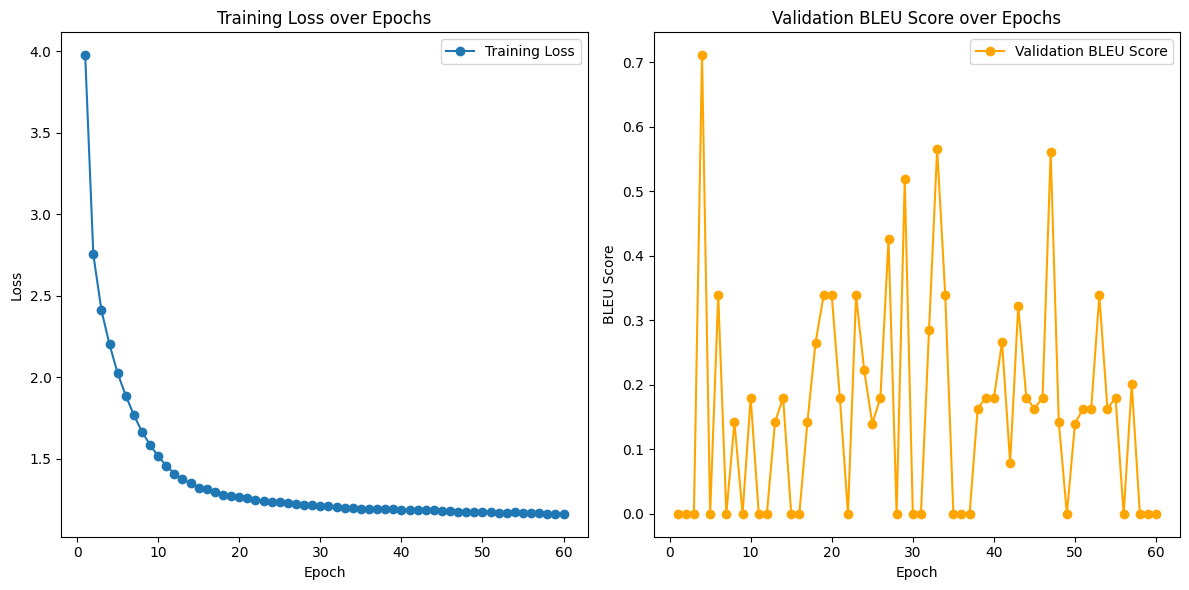

In [24]:

# Train our model
train_model(preload_epoch=None)

In [25]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

count_parameters(model)

Total parameters: 47072157
Trainable parameters: 47072157


In [26]:
##### Lower parameter

In [27]:
# Example configuration
source_vocab_size = tokenizer_en.get_vocab_size()
target_vocab_size = tokenizer_my.get_vocab_size()
source_seq_len = max_seq_len
target_seq_len = max_seq_len
d_model = 256
num_blocks = 4
num_heads = 4
d_ff = 1024
dropout_rate = 0.1

In [28]:
# Build the model with the corrected function call
model2 = build_model(
    source_vocab_size=source_vocab_size,
    target_vocab_size=target_vocab_size,
    source_seq_len=source_seq_len,
    target_seq_len=target_seq_len,
    d_model=d_model,
    num_blocks=num_blocks,
    num_heads=num_heads,
    dropout_rate=dropout_rate,
    d_ff=d_ff
).to(device)

In [29]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

count_parameters(model2)

Total parameters: 8858013
Trainable parameters: 8858013


In [30]:
import torch
import torch.nn as nn

class AddAndNorm(nn.Module):
    def __init__(self, size, dropout):
        super(AddAndNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, sub_layer):
        output = input + self.dropout(sub_layer(self.layer_norm(input)))
        return output

class FeedForward(nn.Module):
    def __init__(self, size, d_ff, dropout):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(size, d_ff)
        self.linear2 = nn.Linear(d_ff, size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

class MultiHeadAttention(nn.Module):
    def __init__(self, size, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()
        assert size % num_heads == 0

        self.size = size
        self.num_heads = num_heads
        self.head_dim = size // num_heads

        self.query = nn.Linear(size, size)
        self.key = nn.Linear(size, size)
        self.value = nn.Linear(size, size)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(size, size)

    def forward(self, query, key, value, mask):
        batch_size = query.size(0)
        def transform(x, module):
            return module(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        query = transform(query, self.query)
        key = transform(key, self.key)
        value = transform(value, self.value)
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = torch.softmax(scores, dim=-1)
        attention = self.dropout(attention)
        x = torch.matmul(attention, value).transpose(1, 2).contiguous().view(batch_size, -1, self.size)
        return self.out(x)

class EncoderBlock(nn.Module):
    def __init__(self, size, num_heads, d_ff, dropout):
        super(EncoderBlock, self).__init__()
        self.multihead_attention = MultiHeadAttention(size, num_heads, dropout)
        self.addnorm_1 = AddAndNorm(size, dropout)
        self.feed_forward = FeedForward(size, d_ff, dropout)
        self.addnorm_2 = AddAndNorm(size, dropout)

    def forward(self, encoder_input, encoder_mask):
        encoder_input = self.addnorm_1(encoder_input, lambda x: self.multihead_attention(x, x, x, encoder_mask))
        encoder_input = self.addnorm_2(encoder_input, self.feed_forward)
        return encoder_input

class Encoder(nn.Module):
    def __init__(self, size, num_blocks, num_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.encoderblocklist = nn.ModuleList([EncoderBlock(size, num_heads, d_ff, dropout) for _ in range(num_blocks)])
        self.layer_norm = nn.LayerNorm(size)

    def forward(self, encoder_input, encoder_mask):
        for encoderblock in self.encoderblocklist:
            encoder_input = encoderblock(encoder_input, encoder_mask)
        return self.layer_norm(encoder_input)

class TransformerModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, source_seq_len, target_seq_len, d_model, num_blocks, num_heads, d_ff, dropout):
        super(TransformerModel, self).__init__()
        self.source_embed = nn.Embedding(source_vocab_size, d_model)
        self.target_embed = nn.Embedding(target_vocab_size, d_model)
        self.source_pos = nn.Embedding(source_seq_len, d_model)
        self.target_pos = nn.Embedding(target_seq_len, d_model)
        self.encoder = Encoder(d_model, num_blocks, num_heads, d_ff, dropout)
        self.decoder = Encoder(d_model, num_blocks, num_heads, d_ff, dropout)  # Using the same Encoder block for simplicity
        self.project = nn.Linear(d_model, target_vocab_size)

    def encode(self, encoder_input, encoder_mask):
        encoder_input = self.source_embed(encoder_input) + self.source_pos(torch.arange(encoder_input.size(1), device=encoder_input.device)).unsqueeze(0)
        return self.encoder(encoder_input, encoder_mask)

    def decode(self, encoder_output, encoder_mask, decoder_input, decoder_mask):
        decoder_input = self.target_embed(decoder_input) + self.target_pos(torch.arange(decoder_input.size(1), device=decoder_input.device)).unsqueeze(0)
        return self.decoder(decoder_input, decoder_mask)

    def forward(self, encoder_input, encoder_mask, decoder_input, decoder_mask):
        encoder_output = self.encode(encoder_input, encoder_mask)
        return self.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)


In [31]:
def build_model(source_vocab_size, target_vocab_size, source_seq_len, target_seq_len, d_model=512, num_blocks=6, num_heads=8, d_ff=2048, dropout=0.1):
    return TransformerModel(source_vocab_size, target_vocab_size, source_seq_len, target_seq_len, d_model, num_blocks, num_heads, d_ff, dropout) # Use the TransformerModel class to create a new model instance

In [ ]:


def causal_mask(size):
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask

def run_evaluation(model2, validation_ds, tokenizer_en, tokenizer_my, max_seq_len, device):
    model2.eval()
    reference_texts = []
    generated_texts = []

    with torch.no_grad():
        for batch in validation_ds:
            encoder_input = batch["encoder_input"].to(device)
            encoder_mask = batch["encoder_mask"].to(device)

            cls_id = tokenizer_my.token_to_id('[CLS]')
            sep_id = tokenizer_my.token_to_id('[SEP]')

            encoder_output =model2.encode(encoder_input, encoder_mask)
            decoder_input = torch.empty(1, 1).fill_(cls_id).type_as(encoder_input).to(device)

            while True:
                if decoder_input.size(1) == max_seq_len:
                    break

                decoder_mask = causal_mask(decoder_input.size(1)).type_as(encoder_mask).to(device)
                out = model2.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
                prob = model2.project(out[:, -1])
                _, next_word = torch.max(prob, dim=1)
                decoder_input = torch.cat(
                    [decoder_input, torch.empty(1, 1).type_as(encoder_input).fill_(next_word.item()).to(device)], dim=1
                )
                if next_word == sep_id:
                    break
            model_out = decoder_input.squeeze(0)
            model_out_text = tokenizer_my.decode(model_out.detach().cpu().numpy())

            target_text = batch["target_text"][0]

            reference_texts.append([target_text.split()])
            generated_texts.append(model_out_text.split())

    bleu_score = corpus_bleu(reference_texts, generated_texts)
    print(f'BLEU score: {bleu_score:.4f}')
    return bleu_score

def train_model(model2, train_dataloader, val_dataloader, tokenizer_en, tokenizer_my, max_seq_len, device, preload_epoch=None):
    EPOCHS = 60
    initial_epoch = 0
    global_step = 0

    optimizer = torch.optim.Adam(model2.parameters(), lr=3e-4, eps=1e-9)
    batch_size = 32  # Adjust the batch size here

    if preload_epoch is not None:
        model_filename = f"./Yorubagpt/model_{preload_epoch}.pt"
        state = torch.load(model_filename)
        model2.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_en.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    # Lists to store metrics
    train_losses = []
    val_bleu_scores = []

    for epoch in range(initial_epoch, EPOCHS):
        model2.train()
        epoch_loss = 0.0
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)
            target_label = batch['target_label'].to(device)

            encoder_output = model2.encode(encoder_input, encoder_mask)
            decoder_output = model2.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            projection_output = model2.project(decoder_output)

            loss = loss_fn(projection_output.view(-1, tokenizer_my.get_vocab_size()), target_label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1
            epoch_loss += loss.item()

        epoch_loss /= len(train_dataloader)
        train_losses.append(epoch_loss)

        # Validation Block
        print(f"Validation for Epoch {epoch}")
        bleu_score = run_evaluation(model2, val_dataloader, tokenizer_en, tokenizer_my, max_seq_len, device)
        val_bleu_scores.append(bleu_score)
        print(f"BLEU score for Epoch {epoch}: {bleu_score:.4f}")

        model_filename = f"./Yorubagpt/model_{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), val_bleu_scores, marker='o', label='Validation BLEU Score', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example configuration
source_vocab_size = tokenizer_en.get_vocab_size()
target_vocab_size = tokenizer_my.get_vocab_size()
source_seq_len = max_seq_len
target_seq_len = max_seq_len
d_model = 256
num_blocks = 4
num_heads = 4
d_ff = 1024
#dropout_rate = 0.1

# Build the model with the corrected function call
model2 = build_model(
    source_vocab_size=source_vocab_size,
    target_vocab_size=target_vocab_size,
    source_seq_len=source_seq_len,
    target_seq_len=target_seq_len,
    d_model=d_model,
    num_blocks=num_blocks,
    num_heads=num_heads,
    d_ff=d_ff
).to(device)

# Assuming `train_dataloader`, `val_dataloader`, `tokenizer_en`, `tokenizer_my`, and `device` are defined elsewhere
train_model(model2, train_dataloader, val_dataloader, tokenizer_en, tokenizer_my, source_seq_len, device)


Processing Epoch 00: 100%|██████████| 581/581 [00:17<00:00, 32.61it/s, loss=1.130]


Validation for Epoch 0
BLEU score: 0.0000
BLEU score for Epoch 0: 0.0000


Processing Epoch 01: 100%|██████████| 581/581 [00:17<00:00, 33.98it/s, loss=1.126]


Validation for Epoch 1


In [ ]:


def causal_mask(size):
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask

def run_evaluation(transformer_model, validation_ds, tokenizer_en, tokenizer_my, max_seq_len, device):
    transformer_model.eval()
    reference_texts = []
    generated_texts = []

    with torch.no_grad():
        for batch in validation_ds:
            encoder_input = batch["encoder_input"].to(device)
            encoder_mask = batch["encoder_mask"].to(device)

            cls_id = tokenizer_my.token_to_id('[CLS]')
            sep_id = tokenizer_my.token_to_id('[SEP]')

            encoder_output = transformer_model.encode(encoder_input, encoder_mask)
            decoder_input = torch.empty(1, 1).fill_(cls_id).type_as(encoder_input).to(device)

            while True:
                if decoder_input.size(1) == max_seq_len:
                    break

                decoder_mask = causal_mask(decoder_input.size(1)).type_as(encoder_mask).to(device)
                out = transformer_model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
                prob = transformer_model.project(out[:, -1])
                _, next_word = torch.max(prob, dim=1)
                decoder_input = torch.cat(
                    [decoder_input, torch.empty(1, 1).type_as(encoder_input).fill_(next_word.item()).to(device)], dim=1
                )
                if next_word == sep_id:
                    break
            model_out = decoder_input.squeeze(0)
            model_out_text = tokenizer_my.decode(model_out.detach().cpu().numpy())

            target_text = batch["target_text"][0]

            reference_texts.append([target_text.split()])
            generated_texts.append(model_out_text.split())

    bleu_score = corpus_bleu(reference_texts, generated_texts)
    print(f'BLEU score: {bleu_score:.4f}')
    return bleu_score

def train_model(transformer_model, train_dataloader, val_dataloader, tokenizer_en, tokenizer_my, max_seq_len, device, preload_epoch=None):
    EPOCHS = 60
    initial_epoch = 0
    global_step = 0

    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=3e-4, eps=1e-9)
    batch_size = 32  # Adjust the batch size here

    if preload_epoch is not None:
        model_filename = f"./Yorubagpt/model_{preload_epoch}.pt"
        state = torch.load(model_filename)
        transformer_model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_en.token_to_id('[PAD]'), label_smoothing=0.1).to(device)

    # Lists to store metrics
    train_losses = []
    val_bleu_scores = []

    for epoch in range(initial_epoch, EPOCHS):
        transformer_model.train()
        epoch_loss = 0.0
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch:02d}")
        for batch in batch_iterator:
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)
            target_label = batch['target_label'].to(device)

            encoder_output = transformer_model.encode(encoder_input, encoder_mask)
            decoder_output = transformer_model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            projection_output = transformer_model.project(decoder_output)

            loss = loss_fn(projection_output.view(-1, tokenizer_my.get_vocab_size()), target_label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            global_step += 1
            epoch_loss += loss.item()

        epoch_loss /= len(train_dataloader)
        train_losses.append(epoch_loss)

        # Validation Block
        print(f"Validation for Epoch {epoch}")
        bleu_score = run_evaluation(transformer_model, val_dataloader, tokenizer_en, tokenizer_my, max_seq_len, device)
        val_bleu_scores.append(bleu_score)
        print(f"BLEU score for Epoch {epoch}: {bleu_score:.4f}")

        model_filename = f"./Yorubagpt/model_{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': transformer_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS + 1), val_bleu_scores, marker='o', label='Validation BLEU Score', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Example configuration
source_vocab_size = tokenizer_en.get_vocab_size()
target_vocab_size = tokenizer_my.get_vocab_size()
source_seq_len = max_seq_len
target_seq_len = max_seq_len
d_model = 512
num_blocks = 6
num_heads = 8
d_ff = 2038
#dropout_rate = 0.1

# Build the model with the corrected function call
transformer_model2 = build_model(
    source_vocab_size=source_vocab_size,
    target_vocab_size=target_vocab_size,
    source_seq_len=source_seq_len,
    target_seq_len=target_seq_len,
    d_model=d_model,
    num_blocks=num_blocks,
    num_heads=num_heads,
    d_ff=d_ff
).to(device)


Processing Epoch 00: 100%|██████████| 222/222 [00:17<00:00, 12.96it/s, loss=3.599]


Validation for Epoch 0
BLEU score: 0.0000
BLEU score for Epoch 0: 0.0000


Processing Epoch 01: 100%|██████████| 222/222 [00:17<00:00, 12.39it/s, loss=1.087]


Validation for Epoch 1
BLEU score: 0.0000
BLEU score for Epoch 1: 0.0000


Processing Epoch 02: 100%|██████████| 222/222 [00:18<00:00, 12.28it/s, loss=1.115]


Validation for Epoch 2
BLEU score: 0.0000
BLEU score for Epoch 2: 0.0000


Processing Epoch 03: 100%|██████████| 222/222 [00:18<00:00, 12.32it/s, loss=1.087]


Validation for Epoch 3
BLEU score: 0.0000
BLEU score for Epoch 3: 0.0000


Processing Epoch 04: 100%|██████████| 222/222 [00:18<00:00, 12.23it/s, loss=1.079]


Validation for Epoch 4
BLEU score: 0.0000
BLEU score for Epoch 4: 0.0000


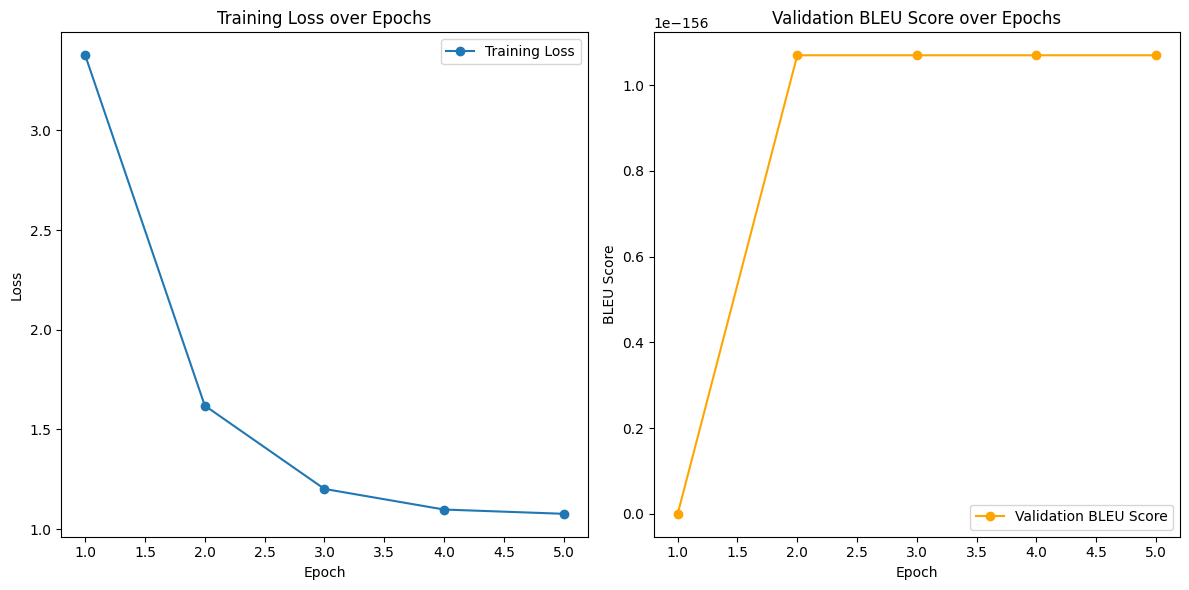

In [ ]:
# Assuming `train_dataloader`, `val_dataloader`, `tokenizer_en`, `tokenizer_my`, and `device` are defined elsewhere
train_model(transformer_model2, train_dataloader, val_dataloader, tokenizer_en, tokenizer_my, source_seq_len, device)